### Test 5
## Evaluating the quality of POINT-E generated clouds with standard metrics on a single object
In this notebook we evaluate the quality of pre-trained POINT-E (300M, 1B) on a CAD object rendered with PyTorch 3D.
We measure the point-cloud divergence with [P-FID](https://en.wikipedia.org/wiki/Fréchet_inception_distance) and [P-IS](https://en.wikipedia.org/wiki/Inception_score) as proposed by the authors of the Point-E paper. 

- P-FID: point cloud Frechet Inception Distance, that is the divergence between ground truth samples and generated ones.
- P-IS: point cloud Inception Score, inversely proportional to the entropy of the predicted semantic labels from the generated point clouds. It measures the sharpness of the distribution of synthetic samples.

We find that P-FID may not be always reliable as PointNet is not invariant to all object transformations: point-e generates normalized point clouds but the orientation is random; a 3d object may have a random rotation/position initially.
This demostrative notebook tests single-view point-e. Further evaluations on multi-view have been conducted in the subsequent notebooks.

In [2]:
from PIL import Image
import torch
from tqdm.auto import tqdm
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler

import pytorch3d

In [ ]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("1.13.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene

from pytorch3d.utils import ico_sphere
from pytorch3d.io import load_obj
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import chamfer_distance

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

In [1]:
# Initial setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_points = 1024
num_views = 4

In [7]:
# Downloading the object to render
!wget https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj

--2023-02-07 17:31:55--  https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [text/plain]
Saving to: ‘teapot.obj.1’

teapot.obj.1        100%[===================>] 149.02K   248KB/s    in 0.6s    

2023-02-07 17:31:56 (248 KB/s) - ‘teapot.obj.1’ saved [152595/152595]



In [8]:
# Use an ico_sphere mesh and load a mesh from an .obj e.g. model.obj
verts, faces, _ = load_obj("teapot.obj")
teapot_mesh = Meshes(verts=[verts], faces=[faces.verts_idx]).to(device)

In [9]:
# Synthetic texture based on sin
c=torch.abs(torch.sin(torch.stack([torch.arange(0,teapot_mesh.verts_list()[0].shape[0]),torch.arange(0,teapot_mesh.verts_list()[0].shape[0]),torch.arange(0,teapot_mesh.verts_list()[0].shape[0])],dim=1))).to(device)
c=c[None,:] # with this trick we add a texture to the mesh even if there is no texture
verts_rgb = torch.zeros([1, teapot_mesh.verts_list()[0].shape[0], 3], device=device)+c
teapot_mesh.textures = TexturesVertex(verts_features=verts_rgb)


# make the scene centered in offset
verts = teapot_mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
teapot_mesh.offset_verts_(-center)
teapot_mesh.scale_verts_((1.0 / float(scale)));

### Rendering views from a test OBJ 

In [10]:
# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

# We will also create a Phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

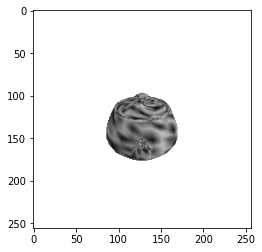

In [11]:
# Select the viewpoint using spherical angles  
distance = 3   # distance from camera to the object
elevation = 30.0   # angle of elevation in degrees
azimuth = 90.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T. 
silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.imshow(image_ref.squeeze())
plt.grid(False)

In [12]:
import random

ground_views = []
elevations = random.choices(list(range(90)), k=num_views)
angles = random.choices(list(range(90)), k=num_views)

# Rendering multiple views from mesh
for i in range(num_views):
  # render view
  R, T = look_at_view_transform(distance, elevations[i], angles[i], device=device)
  image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)
  
  # channel 4 is the alpha channel
  img = (image_ref.cpu().numpy().squeeze()[:,:,:3] * 255).astype(np.uint8)
  ground_views.append(Image.fromarray(img))

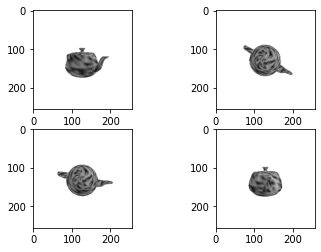

In [13]:
cols = 2
rows = (num_views // cols)
f, axarr = plt.subplots(rows, cols)
for i in range(num_views):
    axarr[i // cols, i % cols].imshow(ground_views[i])

### Point cloud generation with Point-E (single-view)

In [14]:
from mv_point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from mv_point_e.diffusion.sampler import PointCloudSampler
from mv_point_e.models.download import load_checkpoint
from mv_point_e.models.configs import MODEL_CONFIGS, model_from_config
from mv_point_e.util.plotting import plot_point_cloud

In [15]:
base_name = 'base300M' # base40M, use base300M or base1B for better results

# Instatiation of the single-view model, initially
MODEL_CONFIGS[base_name]["n_views"] = 1
MODEL_CONFIGS['upsample']["n_views"] = 1

print('creating base model...')
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
[-] Low Res Diff Transformer set with 1024+256*1 input tokens.
creating upsample model...
[-] High Res Diff Transformer set with 3072+256*1 input tokens.
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [16]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[num_points, 4096-num_points], # points in cloud and missing ones for upsampling
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

In [17]:
# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=ground_views))):
    samples = x

0it [00:00, ?it/s]

In [18]:
samples.shape

torch.Size([1, 6, 4096])

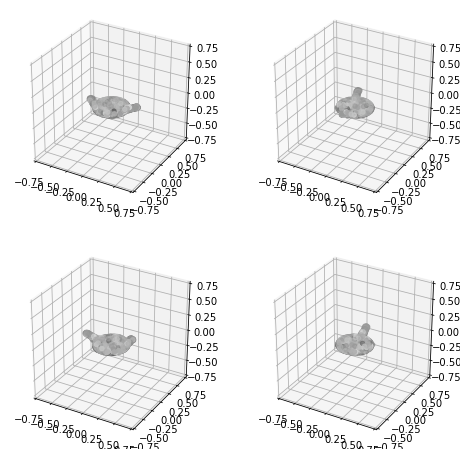

In [19]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

### Generated point cloud (colorless)

In [34]:
samples.size()

torch.Size([1, 6, 4096])

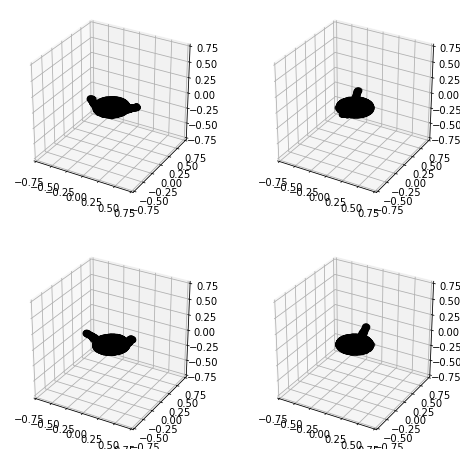

In [21]:
# Comparable now with colorless clouds
gen_colorless = samples[0, :3, :]
blacks = torch.zeros((3, gen_colorless.shape[1])).to(device)
gen_colorless = torch.cat((gen_colorless, blacks), 0).unsqueeze(0)

generated_pc = sampler.output_to_point_clouds(gen_colorless)[0]
fig = plot_point_cloud(generated_pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

### Ground point cloud

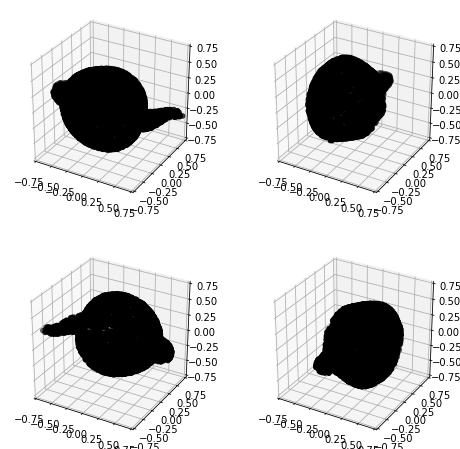

In [22]:
ground_point_cloud = sample_points_from_meshes(teapot_mesh, num_samples=4096).cpu()[0]
ground_point_cloud = ground_point_cloud.permute(1, 0)

blacks = torch.zeros((3, ground_point_cloud.shape[1]))
ground_point_cloud = torch.cat((ground_point_cloud, blacks), 0).unsqueeze(0).cpu()

generated_pc = sampler.output_to_point_clouds(ground_point_cloud)[0]
fig = plot_point_cloud(generated_pc, grid_size=2, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [23]:
print("Ground truth min/max: \t\t{}, {}".format(ground_point_cloud.min(), ground_point_cloud.max()))
print("Generated truth min/max: \t\t{}, {}".format(gen_colorless.min(), gen_colorless.max()))

Ground truth min/max: 		-0.9007291197776794, 0.9870772957801819
Generated truth min/max: 		-0.2919454872608185, 0.3951907157897949


### P-FID, P-IS score test

In [24]:
ground = ground_point_cloud.cpu().permute(0,2,1).numpy()[:,:,:3]
gen = gen_colorless.cpu().permute(0,2,1).numpy()[:,:,:3]
np.savez("ground.npz", ground)
np.savez("generated.npz", gen)

**Single sample P-FID**

In [25]:
from mv_point_e.evals.feature_extractor import PointNetClassifier, get_torch_devices
from mv_point_e.evals.fid_is import compute_statistics
from mv_point_e.evals.fid_is import compute_inception_score
from mv_point_e.evals.npz_stream import NpzStreamer

"""
Idea: PointNet should extract very similar features between two point clouds, thus their distance shall be short.
"""

clf = PointNetClassifier(devices=get_torch_devices(), cache_dir=None)

features_1, preds1 = clf.features_and_preds(NpzStreamer("ground.npz"))
stats_1 = compute_statistics(features_1)
del features_1

features_2, preds2 = clf.features_and_preds(NpzStreamer("generated.npz"))
stats_2 = compute_statistics(features_2)
del features_2

# problem: probably PointNet is not invariant to all rotations (and scale?)
print(f"P-FID: {stats_1.frechet_distance(stats_2)}")

P-FID: 214.17352584217056


**Single sample P-IS**

In [26]:
# https://github.com/halixness/point-e/blob/69e677d8ea47593c33fe2f52fd40e131054c9ce3/point_e/evals/fid_is.py#L73
# problem: scale and rotation seem to influence the prediction

score = np.exp(
  np.sum(
    preds2[0] * ( np.log(preds2[0]) - np.log(np.mean(preds2[0])) )
  )
)

print(f"P-IS: {score}, Max pred: {preds2.max()}")

P-IS: 6.10969352722168, Max pred: 0.2887074053287506


In [29]:
# y = labels from the ground_truth cloud
# p(x) = labels from the point-e generated cloud

multi_cross_entropy = -np.sum(preds1 * np.log(preds2))

print(f"Cross Entropy predictions: {multi_cross_entropy}")

Cross Entropy predictions: 6.068268775939941
